In [1]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt

import random

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import xarray as xr
import torch.optim as optim
from tqdm import tqdm

from collections import Counter
import itertools

from sklearn.metrics import roc_auc_score, precision_score, recall_score

In [2]:
! pip install cartopy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 121.5 MB/s eta 0:00:00


In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [4]:
# Suppress specific warning types
import warnings
warnings.filterwarnings("ignore", message="To copy construct from a tensor")
warnings.filterwarnings("ignore", message="nn.functional.sigmoid is deprecated")
warnings.filterwarnings("ignore", message="User provided device_type of 'cuda'")

In [5]:
def set_and_print_seed(seed=None):
    if seed is None:
        # Generate a random seed if none is provided
        seed = np.random.randint(0, 100000)

    print(f"Using random seed: {seed}")

    # Set all seeds
    np.random.seed(seed)
    torch.manual_seed(seed)
    random.seed(seed)

    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

    return seed

In [6]:
class CropDataset(Dataset):
    def __init__(self, X, static, y, w):
        """
        Args:
            X (np.array): Time-series images of shape (num_samples, time_steps, 3, 4, 4).
            static (np.array): Static features of shape (num_samples, 6).
            y (np.array): Binary targets of shape (num_samples,).
        """
        self.X = X.astype(np.float32)
        self.static = static.astype(np.float32)
        self.y = y.astype(np.float32)
        self.weights = torch.tensor(w, dtype=torch.float32)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        # Convert the numpy arrays to torch tensors.
        x = torch.tensor(self.X[idx])            # (time_steps, 3, 4, 4)
        static_feat = torch.tensor(self.static[idx])  # (6,)
        label = torch.tensor(self.y[idx]).unsqueeze(0)  # (1,)
        weight = torch.tensor(self.weights[idx])
        return x, static_feat, label, weight

In [7]:
class SelfAttention(nn.Module):
    def __init__(self, input_dim, attention_dim):
        """
        Self-attention mechanism to aggregate LSTM outputs.

        Args:
            input_dim (int): Dimensionality of the LSTM output.
            attention_dim (int): Internal dimension for attention computation.
        """
        super(SelfAttention, self).__init__()
        self.attention_fc = nn.Linear(input_dim, attention_dim)
        self.context_vector = nn.Linear(attention_dim, 1, bias=False)

    def forward(self, lstm_out):
        # lstm_out: (batch, time_steps, input_dim)
        energy = torch.tanh(self.attention_fc(lstm_out))      # (batch, time_steps, attention_dim)
        attn_weights = self.context_vector(energy)            # (batch, time_steps, 1)
        attn_weights = F.softmax(attn_weights, dim=1)           # normalize over time steps
        context_vector = torch.sum(attn_weights * lstm_out, dim=1)  # (batch, input_dim)
        return context_vector

In [8]:
class HierarchicalFusionModel(nn.Module):
    def __init__(self,
                 cnn_out_dim=32,       # Output dimension from CNN branch per time step
                 static_early_dim=32,   # Dimension for early fusion transformation of static features
                 fusion_dim=64,         # Dimension after fusing CNN features and static early features
                 lstm_hidden_dim=128,   # Hidden size for LSTM processing the fused sequence
                 lstm_layers=1,
                 attention_dim=64,      # Internal dimension for self-attention over LSTM outputs
                 static_late_dim=32,    # Dimension for late fusion transformation of static features
                 combined_hidden_dim=64 # Dimension for the final fully connected layer
                 ):
        super(HierarchicalFusionModel, self).__init__()

        # ----- CNN Branch (per time step) -----
        # For an image of shape (3, 4, 4) a kernel size of 3 produces a (8, 2, 2) output.
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3)  # (8, 2, 2)
        self.bn1 = nn.BatchNorm2d(8)
        # Flatten the conv output and map to cnn_out_dim.
        self.fc_cnn = nn.Linear(8 * 2 * 2, cnn_out_dim)

        # ----- Static Branch for Early Fusion -----
        # Transform static features (6-dim) into a representation for early fusion.
        self.fc_static_early = nn.Linear(6, static_early_dim)

        # ----- Early Fusion -----
        # Concatenate the CNN features (for each time step) with the tiled static features.
        self.fusion_fc = nn.Linear(cnn_out_dim + static_early_dim, fusion_dim)

        # ----- LSTM for the Fused Sequence -----
        self.lstm = nn.LSTM(input_size=fusion_dim,
                            hidden_size=lstm_hidden_dim,
                            num_layers=lstm_layers,
                            batch_first=True)

        # Self-attention to aggregate LSTM outputs over time.
        self.attention = SelfAttention(lstm_hidden_dim, attention_dim)

        # ----- Static Branch for Late Fusion -----
        self.fc_static_late = nn.Linear(6, static_late_dim)

        # ----- Late Fusion and Final Classification -----
        self.fc_final = nn.Linear(lstm_hidden_dim + static_late_dim, combined_hidden_dim)
        self.fc_out = nn.Linear(combined_hidden_dim, 1)  # Logit output for binary classification

    def forward(self, images, static_features):
        """
        Args:
            images: Tensor of shape (batch_size, time_steps, 3, 4, 4)
            static_features: Tensor of shape (batch_size, 6)
        Returns:
            logits: Tensor of shape (batch_size, 1)
        """
        batch_size, time_steps, C, H, W = images.size()
        # --- Process each image with CNN ---
        x = images.view(batch_size * time_steps, C, H, W)        # (batch*time_steps, 3, 4, 4)
        x = F.relu(self.bn1(self.conv1(x)))                      # (batch*time_steps, 8, 2, 2)
        x = x.view(x.size(0), -1)                                # Flatten: (batch*time_steps, 8*2*2)
        cnn_features = F.relu(self.fc_cnn(x))                    # (batch*time_steps, cnn_out_dim)
        cnn_features = cnn_features.view(batch_size, time_steps, -1)  # (batch, time_steps, cnn_out_dim)

        # --- Process static features for early fusion ---
        static_early = F.relu(self.fc_static_early(static_features))  # (batch, static_early_dim)
        # Tile static features across the time dimension.
        static_early_tiled = static_early.unsqueeze(1).repeat(1, time_steps, 1)  # (batch, time_steps, static_early_dim)

        # --- Early Fusion ---
        fused_input = torch.cat([cnn_features, static_early_tiled], dim=-1)  # (batch, time_steps, cnn_out_dim + static_early_dim)
        fused_sequence = F.relu(self.fusion_fc(fused_input))                 # (batch, time_steps, fusion_dim)

        # --- LSTM Processing ---
        lstm_out, _ = self.lstm(fused_sequence)  # (batch, time_steps, lstm_hidden_dim)
        ts_aggregated = self.attention(lstm_out)   # (batch, lstm_hidden_dim)

        # --- Process static features for late fusion ---
        static_late = F.relu(self.fc_static_late(static_features))  # (batch, static_late_dim)

        # --- Late Fusion ---
        combined_features = torch.cat([ts_aggregated, static_late], dim=1)  # (batch, lstm_hidden_dim + static_late_dim)

        # --- Final Classification ---
        x = F.relu(self.fc_final(combined_features))
        logits = self.fc_out(x)  # (batch, 1)
        return logits

In [9]:
class LateFusionModel(nn.Module):
    def __init__(self,
                 cnn_out_dim=32,       # Output dimension from CNN branch per time step
                 lstm_hidden_dim=128,   # Hidden size for LSTM processing the sequence
                 lstm_layers=1,
                 attention_dim=64,      # Internal dimension for self-attention over LSTM outputs
                 static_late_dim=32,    # Dimension for late fusion transformation of static features
                 combined_hidden_dim=64 # Dimension for the final fully connected layer
                 ):
        super(LateFusionModel, self).__init__()

        # ----- CNN Branch (per time step) -----
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3)  # (8, 2, 2)
        self.bn1 = nn.BatchNorm2d(8)
        # Flatten the conv output and map to cnn_out_dim
        self.fc_cnn = nn.Linear(8 * 2 * 2, cnn_out_dim)

        # ----- LSTM for Processing CNN Features -----
        self.lstm = nn.LSTM(input_size=cnn_out_dim,
                           hidden_size=lstm_hidden_dim,
                           num_layers=lstm_layers,
                           batch_first=True)

        # Self-attention to aggregate LSTM outputs over time
        self.attention = SelfAttention(lstm_hidden_dim, attention_dim)

        # ----- Static Branch for Late Fusion -----
        self.fc_static_late = nn.Linear(6, static_late_dim)

        # ----- Late Fusion and Final Classification -----
        self.fc_final = nn.Linear(lstm_hidden_dim + static_late_dim, combined_hidden_dim)
        self.fc_out = nn.Linear(combined_hidden_dim, 1)  # Logit output for binary classification

    def forward(self, images, static_features):
        """
        Args:
            images: Tensor of shape (batch_size, time_steps, 3, 4, 4)
            static_features: Tensor of shape (batch_size, 6)
        Returns:
            logits: Tensor of shape (batch_size, 1)
        """
        batch_size, time_steps, C, H, W = images.size()

        # --- Process each image with CNN ---
        x = images.view(batch_size * time_steps, C, H, W)        # (batch*time_steps, 3, 4, 4)
        x = F.relu(self.bn1(self.conv1(x)))                      # (batch*time_steps, 8, 2, 2)
        x = x.view(x.size(0), -1)                                # Flatten: (batch*time_steps, 8*2*2)
        cnn_features = F.relu(self.fc_cnn(x))                    # (batch*time_steps, cnn_out_dim)
        cnn_features = cnn_features.view(batch_size, time_steps, -1)  # (batch, time_steps, cnn_out_dim)

        # --- LSTM Processing of CNN Features ---
        lstm_out, _ = self.lstm(cnn_features)  # (batch, time_steps, lstm_hidden_dim)
        ts_aggregated = self.attention(lstm_out)   # (batch, lstm_hidden_dim)

        # --- Process static features for late fusion ---
        static_late = F.relu(self.fc_static_late(static_features))  # (batch, static_late_dim)

        # --- Late Fusion ---
        combined_features = torch.cat([ts_aggregated, static_late], dim=1)  # (batch, lstm_hidden_dim + static_late_dim)

        # --- Final Classification ---
        x = F.relu(self.fc_final(combined_features))
        logits = self.fc_out(x)  # (batch, 1)
        return logits

In [10]:
def evaluate_metrics(model, data_loader, device):
    model.eval()
    all_labels = []
    all_probs = []
    with torch.no_grad():
        for images, static_features, labels, weights in data_loader:
            images = images.to(device)
            static_features = static_features.to(device)
            labels = labels.to(device)
            outputs = model(images, static_features)
            # Convert logits to probabilities with sigmoid.
            probs = torch.sigmoid(outputs)
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
    # Flatten arrays
    all_labels = np.array(all_labels).flatten()
    all_probs = np.array(all_probs).flatten()
    print(all_probs)
    # Use 0.5 threshold for class predictions.
    pred_labels = (all_probs >= 0.5).astype(int)
    auc = roc_auc_score(all_labels, all_probs)
    precision = precision_score(all_labels, pred_labels, zero_division=0)
    recall = recall_score(all_labels, pred_labels, zero_division=0)
    return auc, precision, recall

In [11]:
# country_name = 'SA'
crop_type = 'Rice'
# data_path = os.path.join('/content/drive/MyDrive/Colab Notebooks/data/train_data', f'{crop_type}_{country_name}_data.pkl')
data_path = os.path.join('/content/drive/MyDrive/Colab Notebooks/data/train_data', f'{crop_type}_data.pkl')
with open(data_path, 'rb') as pkl_file:
    X, static, y, y_bi, w = pickle.load(pkl_file)

X = np.array(X)
static = np.array(static)
y_bi = np.array(y_bi)
# w = np.array(w)
w = np.ones(len(y_bi))

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/Colab Notebooks/data/train_data/Rice_data.pkl'

In [ ]:
def count_unique_values_cumsum(lst):
    count_dict = dict(Counter(lst))  # Count occurrences
    sorted_items = sorted(count_dict.items())  # Sort dictionary by key (optional)

    # Compute cumulative sum
    cumsum_counts = list(itertools.accumulate([count for _, count in sorted_items]))

    # Convert back to dictionary
    cumsum_dict = {key: cumsum_counts[i] for i, (key, _) in enumerate(sorted_items)}
    return cumsum_dict

# Example
result = count_unique_values_cumsum(static[:,2])
print(result)

# Optionally, print shapes for verification:
print("X shape:", np.array(X).shape)          # Expected: (num_samples, time_steps, 3, 4, 4)
print("Static shape:", np.array(static).shape)  # Expected: (num_samples, 6)
print("y shape:", np.array(y).shape)            # Expected: (num_samples,)

# Time-series split: assume samples are ordered in time.
num_samples = len(y)
split_index = int(0.85 * num_samples)  # Use first 80% for training and the last 20% for validation.
# split_index = 57458
# start= 12102 # 2000
# start= 15634 # 2005
start= 0 # seed = 93259
# start= 57458


{np.float64(1982.0): 753, np.float64(1983.0): 4072, np.float64(1984.0): 7390, np.float64(1985.0): 10710, np.float64(1986.0): 14033, np.float64(1987.0): 17356, np.float64(1988.0): 20677, np.float64(1989.0): 24000, np.float64(1990.0): 27323, np.float64(1991.0): 30645, np.float64(1992.0): 33965, np.float64(1993.0): 37282, np.float64(1994.0): 40602, np.float64(1995.0): 43922, np.float64(1996.0): 47243, np.float64(1997.0): 50572, np.float64(1998.0): 53900, np.float64(1999.0): 57225, np.float64(2000.0): 60552, np.float64(2001.0): 63873, np.float64(2002.0): 67196, np.float64(2003.0): 70525, np.float64(2004.0): 73840, np.float64(2005.0): 77147, np.float64(2006.0): 80459, np.float64(2007.0): 83773, np.float64(2008.0): 87089, np.float64(2009.0): 90408, np.float64(2010.0): 93726, np.float64(2013.0): 96458, np.float64(2014.0): 99190, np.float64(2015.0): 101637}
X shape: (101637, 24, 3, 4, 4)
Static shape: (101637, 6)
y shape: (101637,)


In [ ]:
train_dataset = CropDataset(X[start:split_index], static[start:split_index], y_bi[start:split_index], w[start:split_index])
val_dataset   = CropDataset(X[split_index:], static[split_index:], y_bi[split_index:], w[split_index:])

In [ ]:
seed_dict = {'Brazil_Rice': 98764,
  #            Epoch 55/60
  # Train Loss: 0.6364 | AUC: 0.7016 | Precision: 0.6456 | Recall: 0.4760
  # Val   Loss: 0.6613 | AUC: 0.6666 | Precision: 0.6039 | Recall: 0.6229
             }
round_dict = {'Brazil_Rice': 55, # AUC 0.70
              'Colombia_Rice': 100}

mode = 'explore'

if mode == 'explore':
  set_and_print_seed()
    # DataLoaders
  batch_size = 32
  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
  val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
elif mode == 'train':
  # Set all seeds
    seed = seed_dict[f'{country_name}_{crop_type}']
    np.random.seed(seed)
    torch.manual_seed(seed)
    random.seed(seed)

    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    batch_size = 32
    train_dataset = CropDataset(X, static, y_bi)
    val_dataset   = CropDataset(X[split_index:], static[split_index:], y_bi[split_index:])
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

Using random seed: 44682


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = HierarchicalFusionModel()
model = LateFusionModel()
model.to(device)

criterion = nn.BCEWithLogitsLoss(reduction='none')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 30
train_losses = []
val_losses = []

# To store metrics for each epoch.
train_auc_list = []
train_precision_list = []
train_recall_list = []

val_auc_list = []
val_precision_list = []
val_recall_list = []

for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0.0
    for images, static_features, labels, weight_batch in train_loader:
        images = images.to(device)
        static_features = static_features.to(device)
        labels = labels.to(device)
        weight_batch = weight_batch.to(device)

        optimizer.zero_grad()
        outputs = model(images, static_features)
        loss = criterion(outputs, labels)
        loss = (loss * weight_batch).mean()
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item() * images.size(0)


    epoch_train_loss = running_train_loss / len(train_dataset)
    train_losses.append(epoch_train_loss)

    # Validation loss computation.
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for images, static_features, labels, weights in val_loader:
            images = images.to(device)
            static_features = static_features.to(device)
            labels = labels.to(device)
            weights = weights.to(device)
            outputs = model(images, static_features)
            loss = criterion(outputs, labels)
            loss = (loss * weights).mean()
            running_val_loss += loss.item() * images.size(0)

    epoch_val_loss = running_val_loss / len(val_dataset)
    val_losses.append(epoch_val_loss)

    # Compute metrics on training and validation sets.
    train_auc, train_precision, train_recall = evaluate_metrics(model, train_loader, device)
    val_auc, val_precision, val_recall = evaluate_metrics(model, val_loader, device)

    train_auc_list.append(train_auc)
    train_precision_list.append(train_precision)
    train_recall_list.append(train_recall)

    val_auc_list.append(val_auc)
    val_precision_list.append(val_precision)
    val_recall_list.append(val_recall)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"  Train Loss: {epoch_train_loss:.4f} | AUC: {train_auc:.4f} | Precision: {train_precision:.4f} | Recall: {train_recall:.4f}")
    print(f"  Val   Loss: {epoch_val_loss:.4f} | AUC: {val_auc:.4f} | Precision: {val_precision:.4f} | Recall: {val_recall:.4f}")

# ------------------------------
# 7. Plot the Training Process
# ------------------------------
epochs = np.arange(1, num_epochs+1)

plt.figure(figsize=(12, 5))

# Plot Losses
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss', marker='o')
plt.plot(epochs, val_losses, label='Validation Loss', marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid(True)

# Plot AUC, Precision, and Recall (Validation Metrics)
plt.subplot(1, 2, 2)
plt.plot(epochs, train_auc_list, label='Train AUC', marker='o')
plt.plot(epochs, val_auc_list, label='Val AUC', marker='o')
plt.plot(epochs, train_precision_list, label='Train Precision', marker='o')
plt.plot(epochs, val_precision_list, label='Val Precision', marker='o')
plt.plot(epochs, train_recall_list, label='Train Recall', marker='o')
plt.plot(epochs, val_recall_list, label='Val Recall', marker='o')
plt.xlabel("Epoch")
plt.ylabel("Metric Value")
plt.title("AUC, Precision and Recall")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

[0.4395679  0.5948329  0.53421944 ... 0.29760644 0.7556961  0.2992271 ]
[0.5280753  0.57422954 0.56479734 ... 0.00116448 0.00129223 0.00127732]
Epoch 1/30
  Train Loss: 0.7468 | AUC: 0.6748 | Precision: 0.5729 | Recall: 0.5323
  Val   Loss: 0.7642 | AUC: 0.5967 | Precision: 0.5343 | Recall: 0.5103


KeyboardInterrupt: 

In [ ]:
# Saving the model
torch. save(model.state_dict(), f'/content/drive/MyDrive/Colab Notebooks/model/model_{crop_type}.pth')

In [ ]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

def create_probability_maps(grid_map):
    """
    Create maps showing the most likely category for each season

    Parameters:
    - data: np.array with shape (17428, 3, 12, 3)
    - idx_locations: list of tuples containing (lat_idx, lon_idx) for each coordinate
    """

    # Create a new projection
    projection = ccrs.PlateCarree(central_longitude=180)
    data_transform = ccrs.PlateCarree()

    # Create the plot with cartopy projection
    fig = plt.figure(figsize=(15, 8))
    ax = plt.axes(projection=projection)

    # Add coastlines and country borders
    ax.coastlines(linewidth=0.5)
    ax.add_feature(cfeature.BORDERS, linewidth=0.3)

    # Add gridlines
    gl = ax.gridlines(draw_labels=True, linewidth=0.2, color='gray', alpha=0.5)
    gl.top_labels = False
    gl.right_labels = False

    img = ax.imshow(grid_map,
              transform=data_transform,
              extent=[0, 360, -90, 90],
              vmin=0,
              vmax=1)
    cbar = plt.colorbar(img, ax=ax, orientation="horizontal", pad=0.05)
    cbar.set_label("Probability")  # Label for the colorbar

    # Adjust layout to make room for colorbars
    plt.subplots_adjust(bottom=0.2)

def create_probability_maps(grid_map, state, states):
    """
    Create maps showing the most likely category for each season
    """
    # Create a new projection
    projection = ccrs.PlateCarree(central_longitude=180)
    data_transform = ccrs.PlateCarree()

    # Create figure with specific size
    fig = plt.figure(figsize=(15, 8))

    # Create main map axis with specific position and size
    ax = fig.add_axes([0.1, 0.15, 0.8, 0.75], projection=projection)

    # Add coastlines and country borders
    ax.coastlines(linewidth=0.5)
    ax.add_feature(cfeature.BORDERS, linewidth=0.3)

    # Add gridlines
    gl = ax.gridlines(draw_labels=True, linewidth=0.2, color='gray', alpha=0.5)
    gl.top_labels = False
    gl.right_labels = False

    # Create a blue to red colormap
    colors = plt.cm.RdBu_r

    img = ax.imshow(grid_map,
                   transform=data_transform,
                   extent=[0, 360, -90, 90],
                   vmin=0,
                   vmax=1,
                   cmap=colors)

    # Add title
    ax.set_title(f'State {states[state]} Probability of Crop Yield Decrease',
                 fontsize=14,
                 pad=15,
                 fontweight='bold')

    # Add colorbar with specific position and size
    cax = fig.add_axes([0.1, 0.08, 0.8, 0.03])  # [left, bottom, width, height]
    cbar = plt.colorbar(img, cax=cax, orientation="horizontal")
    cbar.set_label("Probability", fontsize=12)

    filepath = os.path.join('/content/drive/MyDrive/Colab Notebooks/output', f'{crop_type}_{states[state]}.png')
    # Save the figure
    plt.savefig(filepath,
                dpi=300,              # Resolution
                bbox_inches='tight',   # Trim extra white space
                facecolor='white',     # White background
                format='png')          # File format

    return fig, ax

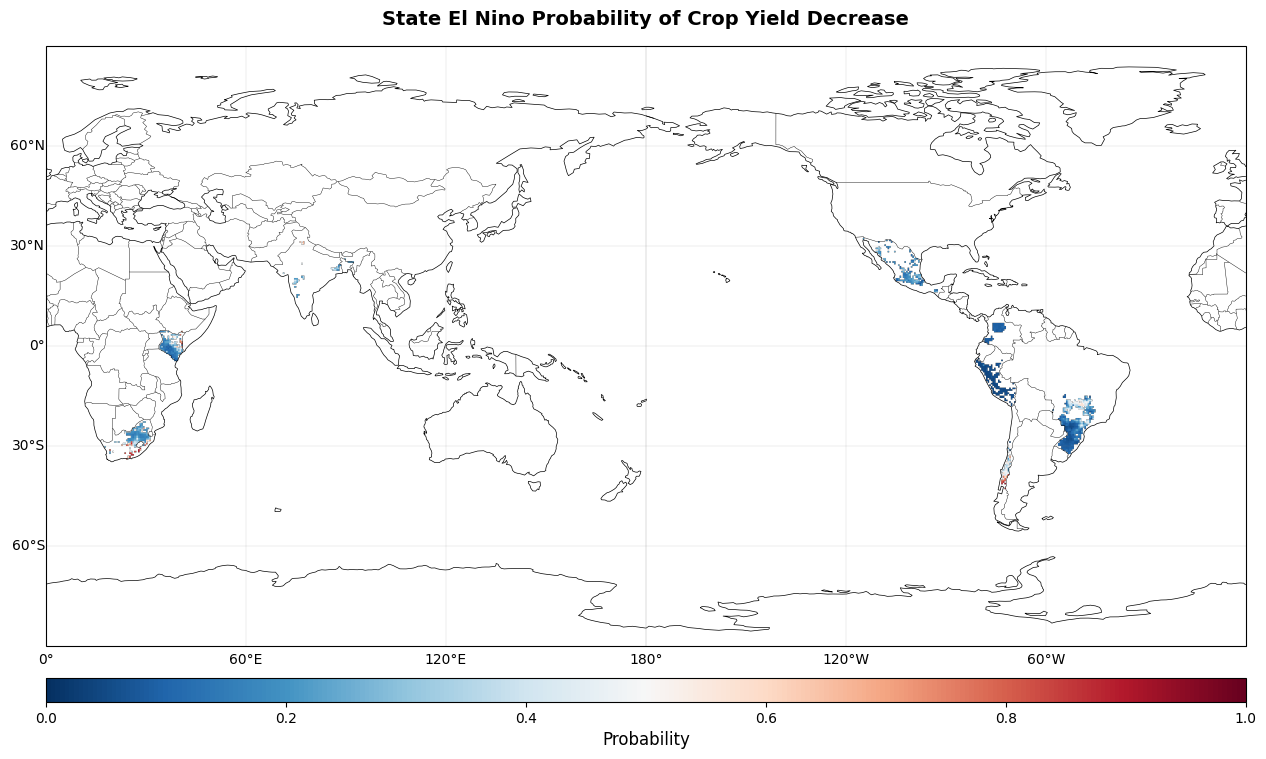

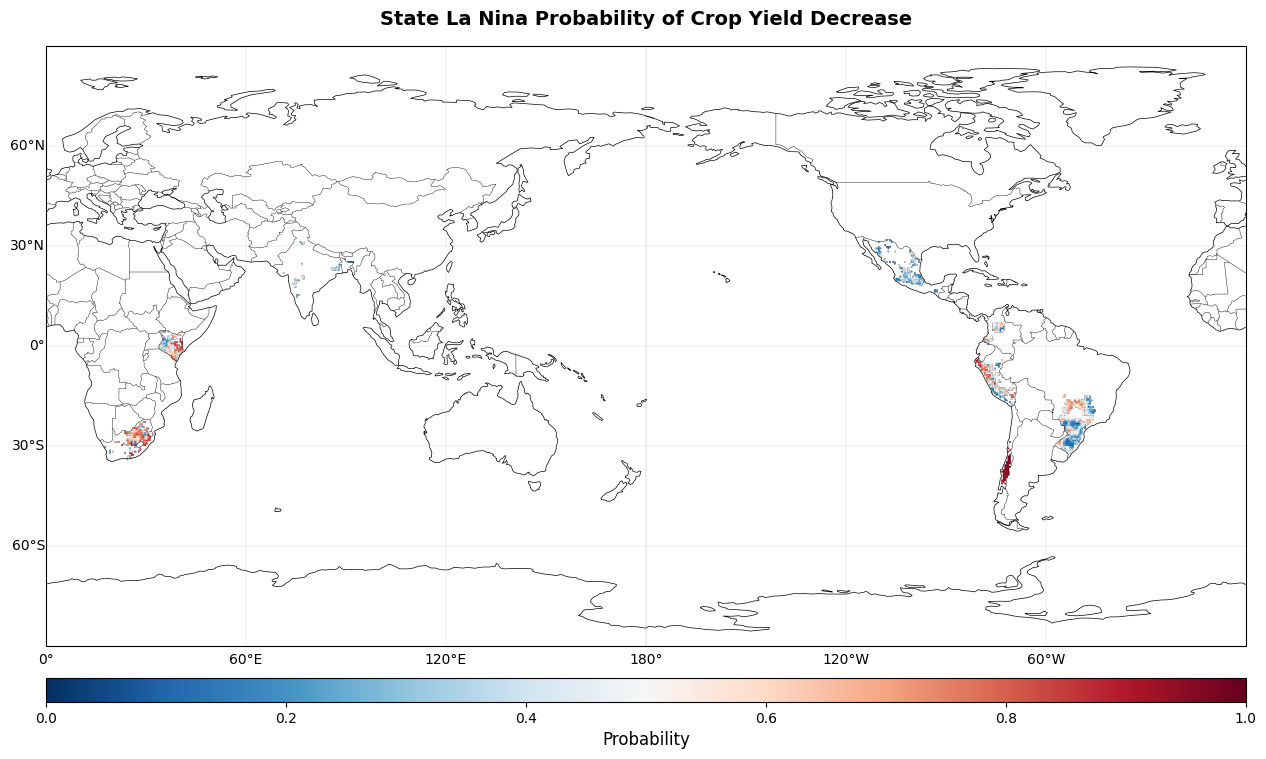

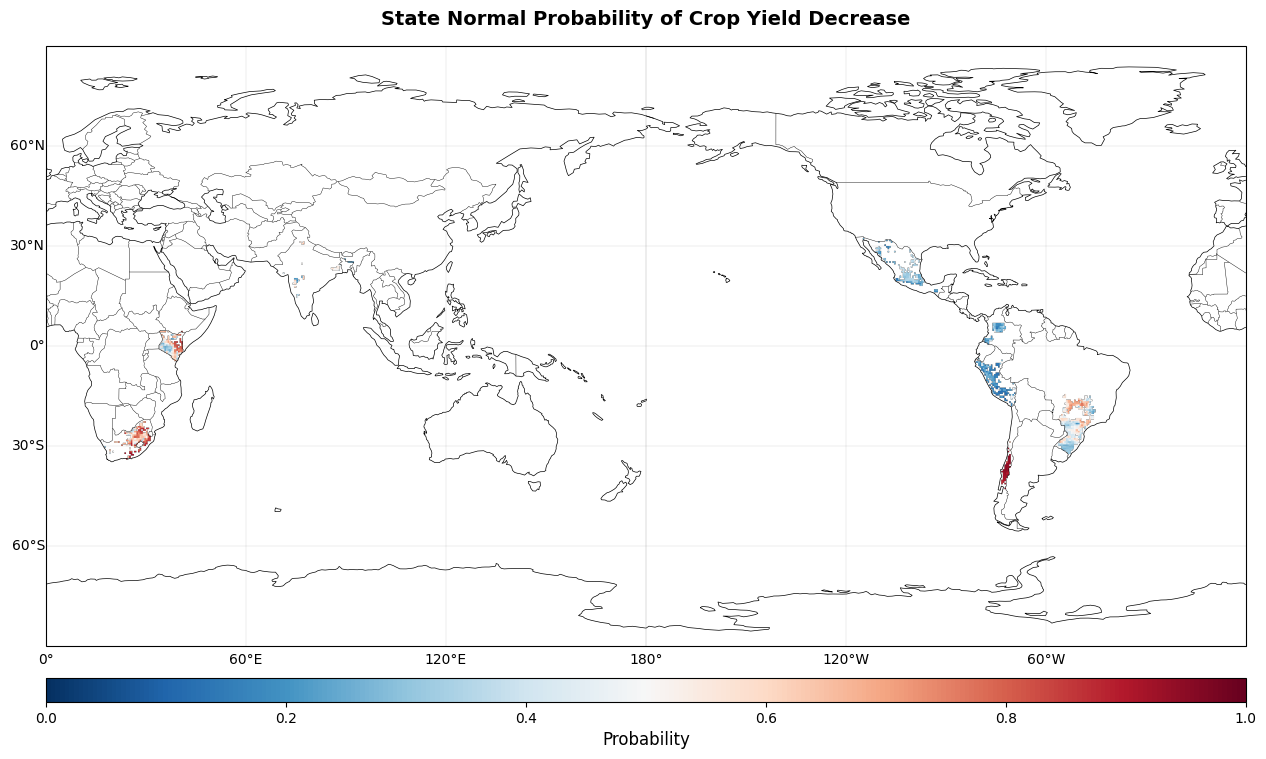

In [ ]:
data_path = os.path.join('/content/drive/MyDrive/Colab Notebooks/data/predict_data', f'{crop_type}_data.pkl')
with open(data_path, 'rb') as pkl_file:
    X_enso, static_enso = pickle.load(pkl_file)

preds = {}

crop = xr.open_dataset('/content/drive/MyDrive/Colab Notebooks/data/yield_1981.nc4')
crop = crop.reindex(lat=crop.lat[::-1])
crop = crop.assign_coords(lon=(((crop.lon + 180) % 360) - 180))
lon_crop = list(crop.lon.values)
lat_crop = list(crop.lat.values)

for state in [0,1,2]:
  X_pre = np.array(X_enso[state])
  X_pre = np.where(X_pre < -0.3, -1, np.where(X_pre > 0.3, 1, 0))
  static_pre = np.array(static_enso[state])
  y_bi_pre = np.ones(len(X_pre))
  w_pre = np.ones(len(X_pre))
  test_dataset   = CropDataset(X_pre, static_pre, y_bi_pre, w_pre)
  new_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
  # ------------------------------
  # 3. Get Predictions from the Model
  # ------------------------------
  model.eval()  # make sure the model is in evaluation mode
  all_preds = []  # to collect predictions
  with torch.no_grad():
      for images, static_features, _, _ in new_loader:
          images = images.to(device)
          static_features = static_features.to(device)
          outputs = model(images, static_features)
          # Use sigmoid to convert logits to probabilities (if you want probabilities)
          probs = torch.sigmoid(outputs)
          all_preds.append(probs.cpu().numpy())
  all_preds = np.concatenate(all_preds, axis=0)  # shape: (N, 1)
  all_preds = all_preds.flatten()  # now shape is (N,)

  preds[state] = all_preds

  lon_lat = np.array(static_enso[state])[:, : 2]

  # Create the final grid map: average predictions in grid cells that have one or more predictions.
  grid_map = np.full((360, 720), np.nan)
  k = 0
  for lon, lat in lon_lat:
    grid_map[lat_crop.index(lat), lon_crop.index(lon)] = all_preds[k]
    k += 1

  # create_probability_maps(grid_map)
  create_probability_maps(grid_map, state, ['El Nino', 'La Nina', 'Normal'])

In [ ]:
preds[0]

array([0.5287706 , 0.52155995, 0.53743047, ..., 0.05662405, 0.02155779,
       0.04910964], dtype=float32)

In [ ]:
preds[1]

array([0.09811118, 0.62374675, 0.06496414, ..., 0.5420627 , 0.39265624,
       0.642503  ], dtype=float32)

In [ ]:
grid_map_true = np.full((360, 720), np.nan)
k = 0
for lon, lat in lon_lat:
  grid_map_true[lat_crop.index(lat), lon_crop.index(lon)] = y_bi[74451:][k]
  k += 1

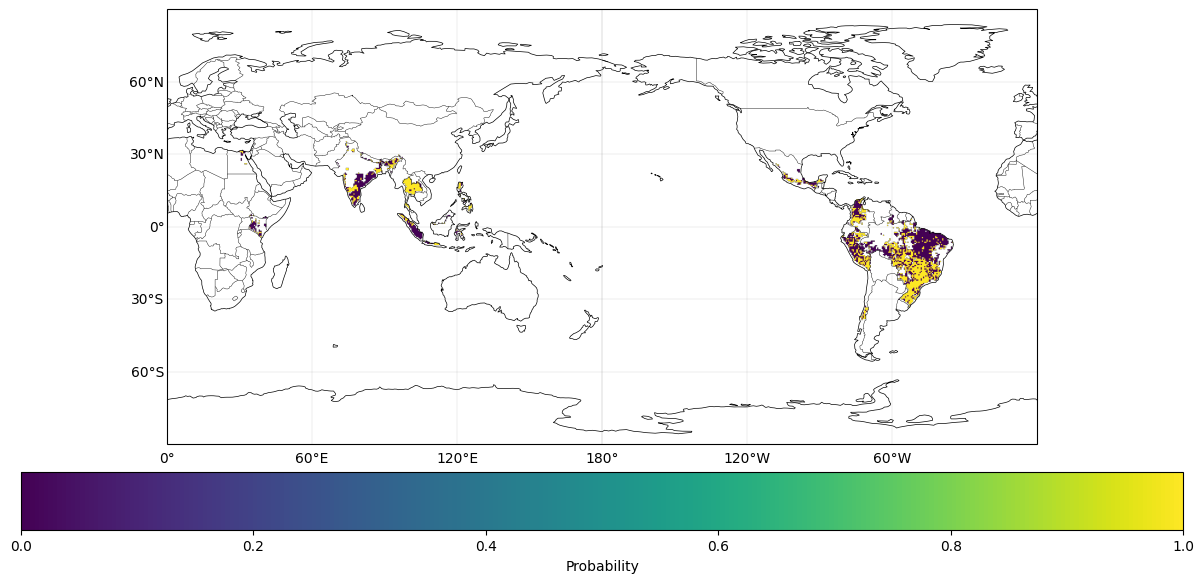

In [ ]:
create_probability_maps(grid_map_true)

In [ ]:
y_bi[96458:][k]

IndexError: index 5179 is out of bounds for axis 0 with size 5179